In [1]:
# Dependencies used in virtual_env
# !pip install -q datasets evaluate transformers[sentencepiece]
# !pip install -q torch
# !pip install -q accelerate==0.26.0
# !pip install scikit-learn
# !pip install -q datasets peft==0.3.0 levenshtein==0.26.1 accelerate==1.2.1 evaluate==0.4.0 transformers==4.45.2
# !pip install -q  torch==2.5.1+cu118 torchaudio==2.5.1+cu118 torchdata==0.5.1 torchvision==0.20.1+cu118

# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu12
# !pip install -U torch==2.2.2 torchvision==0.17.2

# Fine Tuning BERT Model on GLUE Dataset

 ### Setup

In [2]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sea
import os
import gc
import torch
from transformers import DataCollatorWithPadding, get_scheduler
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.auto import tqdm
import evaluate
from sklearn.model_selection import train_test_split
from torch.nn.functional import softmax
import torch.nn.functional as F
import time
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report,accuracy_score
from peft import LoraConfig, get_peft_model, TaskType

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

if torch.cuda.is_available():
   dev = "cuda:0"
else:
   dev = "cpu"
   
device = torch.device(dev)
print('Using {}'.format(device))
gc.collect()
torch.cuda.empty_cache()   

/home/carina/anaconda3/envs/hugging_face_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-10 18:59:01.428090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 18:59:01.596903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736546341.675551   17311 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736546341.701134   17311 cuda_

Using cuda:0


### Data Access

In [3]:
dataframe = pd.read_parquet('../Datasets/pre_processed_dataframes/clean_df.parquet')
dataframe = dataframe[dataframe['language_name'] == 'English'].copy()
valid_categories = ['Sports', 'Entertainment', 'Covid']
dataframe = dataframe[dataframe['Category'].isin(valid_categories)]

df_train, df_test = train_test_split(dataframe, test_size=0.3, stratify=dataframe['Category'])
df_valid, df_test = train_test_split(df_test, test_size=0.3)
len(dataframe), len(df_train), len(df_valid), len(df_test)

(1033, 723, 217, 93)

In [4]:
num_labels = len(df_train['Category'].unique())

### Load Model

In [5]:
checkpoint='google-bert/bert-base-multilingual-uncased'
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(checkpoint)

max_length = tokenizer.model_max_length

print(max_length)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


512


### Data Preprocessing

In [6]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

label_mapping = {category: index for index, category in enumerate(dataframe['Category'].unique())}

label = 'label'
df_train[label] = df_train['Category'].apply(lambda x: label_mapping[x])
df_valid[label] = df_valid['Category'].apply(lambda x: label_mapping[x])
df_test[label] = df_test['Category'].apply(lambda x: label_mapping[x])

model.config.id2label = label_mapping
model.config.label2id = {v: k for k, v in label_mapping.items()}

column_name = 'cleaned_description'
train_dataset, train_label, = list(df_train[column_name]), list(df_train[label].values)
valid_dataset, valid_label, = list(df_valid[column_name]), list(df_valid[label].values)
test_dataset, test_label, = list(df_test[column_name]), list(df_test[label].values)

train_dataset = Dataset.from_dict({"text": train_dataset, "label": train_label})
valid_dataset = Dataset.from_dict({"text": valid_dataset, "label": valid_label})
test_dataset = Dataset.from_dict({"text": test_dataset, "label": test_label})

def preprocess_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True,  max_length=max_length)

train_dataset = train_dataset.map(preprocess_function, batched=True, batch_size=512)
valid_dataset = valid_dataset.map(preprocess_function, batched=True, batch_size=512)
test_dataset = test_dataset.map(preprocess_function, batched=True, batch_size=512)

len(train_dataset), len(valid_dataset), len(test_dataset)

Map: 100%|██████████| 93/93 [00:00<00:00, 2583.86 examples/s]


(723, 217, 93)

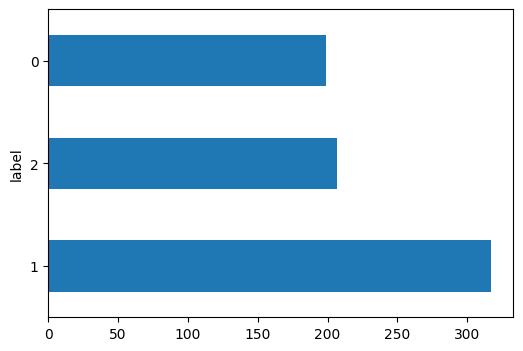

In [7]:
ax = df_train['label'].value_counts().plot(kind='barh', figsize=(6, 4))

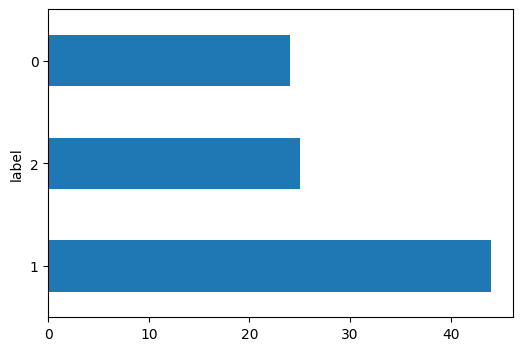

In [8]:
ax = df_test['label'].value_counts().plot(kind='barh', figsize=(6, 4))

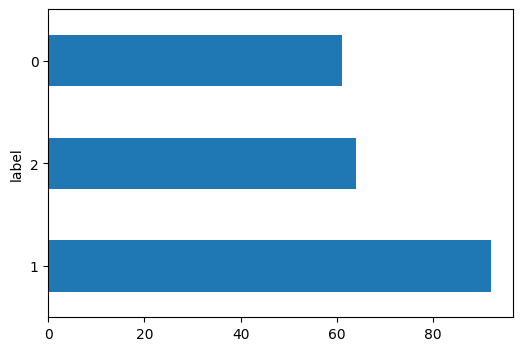

In [9]:
ax = df_valid['label'].value_counts().plot(kind='barh', figsize=(6, 4))

### Data Treatment

#### Generate tokens and attention masks

In [10]:
train_dataset.set_format("torch")
valid_dataset.set_format("torch")
test_dataset.set_format("torch")

In [11]:
train_dataset = train_dataset.remove_columns(["text"])
valid_dataset = valid_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])

In [12]:
test_dataset.column_names

['label', 'input_ids', 'token_type_ids', 'attention_mask']

In [13]:
valid_dataset.column_names

['label', 'input_ids', 'token_type_ids', 'attention_mask']

In [14]:
train_dataset.column_names

['label', 'input_ids', 'token_type_ids', 'attention_mask']

#### Dataloader

In [15]:
batch_size = 2
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

eval_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, collate_fn=data_collator
)

test_dataloader = DataLoader(
    test_dataset, batch_size=1, collate_fn=data_collator
)

In [16]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([2, 512]),
 'token_type_ids': torch.Size([2, 512]),
 'attention_mask': torch.Size([2, 512]),
 'labels': torch.Size([2])}

### Fine Tuning

#### Testing Outputs

In [17]:
cpu_device='cpu'
torch.cuda.empty_cache()
model.to(cpu_device)
batch.to(cpu_device)
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.1580, grad_fn=<NllLossBackward0>) torch.Size([2, 3])


In [18]:
# len batch x len labels
print(outputs.logits)

# labels probabilities
probs = softmax(outputs.logits, dim=-1)  
print(probs)

tensor([[ 0.0417,  0.0496, -0.0415],
        [ 0.0318,  0.0681, -0.0384]], grad_fn=<AddmmBackward0>)
tensor([[0.3415, 0.3442, 0.3143],
        [0.3368, 0.3492, 0.3140]], grad_fn=<SoftmaxBackward0>)


#### Training Loop

In [19]:
gc.collect()
torch.cuda.empty_cache()   

In [20]:
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

def calculate_metrics(true_labels, predictions):
    return {
        "f1": f1_score(true_labels, predictions, average='macro'),
        "accuracy": accuracy_score(true_labels, predictions)
    }

def evaluation(eval_dataloader, model, device):        
    val_acc_loss = 0    
    true_labels = []
    pred_labels = []
    model.eval()

    for val_batch in tqdm(eval_dataloader, total=len(eval_dataloader), desc="Validation", leave=False):
        with torch.no_grad():
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            val_outputs = model(**val_batch)
            val_logits = val_outputs.logits
            val_loss = val_outputs.loss
            val_acc_loss += val_loss.item()                                

            # Acumular predições e rótulos
            predictions_v = torch.argmax(val_logits, dim=1)                        
            true_labels.extend(val_batch['labels'].cpu().numpy())
            pred_labels.extend(predictions_v.cpu().numpy())

    val_mean_loss = val_acc_loss / len(eval_dataloader) if len(eval_dataloader) > 0 else 0
    metrics = calculate_metrics(true_labels, pred_labels)
    return val_mean_loss, metrics


def training_loop(train_dataloader, eval_dataloader, num_epochs, model,
                  optimizer, lr_scheduler, device, model_type='fine_tuning'):    
    os.makedirs("models", exist_ok=True)

    progress_bar = tqdm(range(num_epochs * len(train_dataloader)))
    start_train = time.time()
    best_val_f1 = 0
    early_stopping_patience = max(3, num_epochs // 2)
    early_stopping_counter = 0

    all_training_metrics, all_losses = [], []
    val_losses, val_metrics = [], []

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        all_predictions = []
        all_labels = []
        acc_loss = 0

        for batch in tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1}", leave=False):      
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss    
            acc_loss += loss.item()         

            # Predictions
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            # Save predictions 
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

            # Backward pass
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()        
            progress_bar.update(1)                

        # Metrics for training
        metrics = calculate_metrics(all_labels, all_predictions)    
        all_training_metrics.append(metrics)

        # Mean loss
        mean_loss = acc_loss / len(train_dataloader)
        all_losses.append(mean_loss)
        print(f"epoch {epoch+1}/{num_epochs} - mean loss: {mean_loss:.4f} - f1 score: {metrics['f1']:.4f} - accuracy: {metrics['accuracy']:.4f}")        

        # Validation step
        val_loss, val_metric = evaluation(eval_dataloader, model, device)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        if val_metric['f1'] > best_val_f1:
            best_val_f1 = val_metric['f1']
            early_stopping_counter = 0
            print(f"Epoch {epoch+1}: Saving best model with F1 {val_metric['f1']:.4f}")
            if model_type == 'peft':
                torch.save(model.state_dict(), "models/peft_best_model.pt")
            else:
                torch.save(model.state_dict(), "models/best_model.pt")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    end_train = time.time()
    total_time = (end_train - start_train) / 60
    print(f"Training completed successfully in {total_time:.2f} minutes")
    return val_metrics, val_losses, all_training_metrics, all_losses, total_time

# Training config
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
                                                                                
val_training_metric, val_losses, all_training_metric, all_losses, total_time = training_loop(train_dataloader, eval_dataloader, num_epochs, model, optimizer, lr_scheduler, device)

 33%|███▎      | 362/1086 [01:42<03:18,  3.64it/s]

epoch 1/3 - mean loss: 0.7547 - f1 score: 0.6595 - accuracy: 0.7012


Epoch 1: Saving best model with F1 0.5753


 67%|██████▋   | 724/1086 [03:31<01:36,  3.75it/s]

epoch 2/3 - mean loss: 0.6556 - f1 score: 0.7089 - accuracy: 0.7358


Epoch 2: Saving best model with F1 0.7697


100%|██████████| 1086/1086 [05:20<00:00,  3.75it/s]

epoch 3/3 - mean loss: 0.4519 - f1 score: 0.8422 - accuracy: 0.8575


Epoch 3: Saving best model with F1 0.8384


100%|██████████| 1086/1086 [05:29<00:00,  3.30it/s]

Training completed successfully in 5.49 minutes


#### Model Validation

In [21]:
loss_df = pd.DataFrame()
loss_df['batch'] = range(num_epochs)

loss_df['training loss'] = [l for l in all_losses]
loss_df['val loss'] = [l for l in val_losses]
loss_df['training metric'] =  [item['f1'] for item in all_training_metric]
loss_df['val metric'] =  [item['f1'] for item in val_training_metric]

loss_df


,batch,training loss,val loss,training metric,val metric
0,0,0.754693,0.701503,0.659531,0.575336
1,1,0.655609,0.625253,0.708916,0.769669
2,2,0.451928,0.438864,0.842194,0.838355


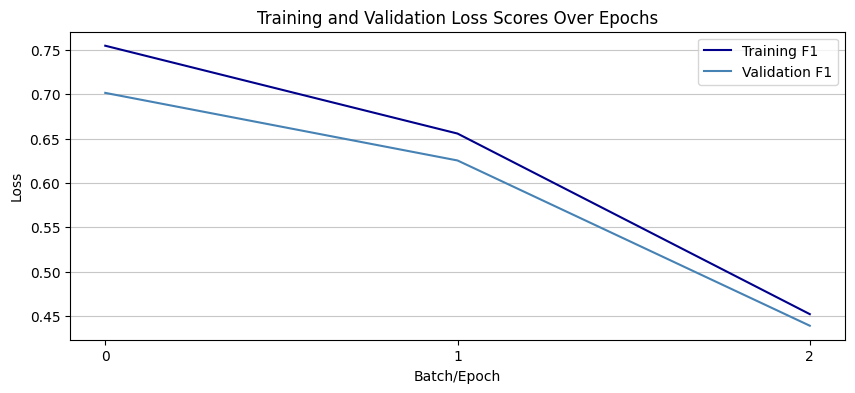

In [22]:
plt.figure(figsize=(10, 4))
sea.lineplot(x=loss_df['batch'], y=loss_df['training loss'], color='darkblue', label='Training F1')
sea.lineplot(x=loss_df['batch'], y=loss_df['val loss'], color='steelblue', label='Validation F1')
plt.title('Training and Validation Loss Scores Over Epochs')
plt.xlabel('Batch/Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.xticks(np.arange(0, num_epochs, step=1))
plt.grid(axis='y', alpha=0.7)
plt.show()

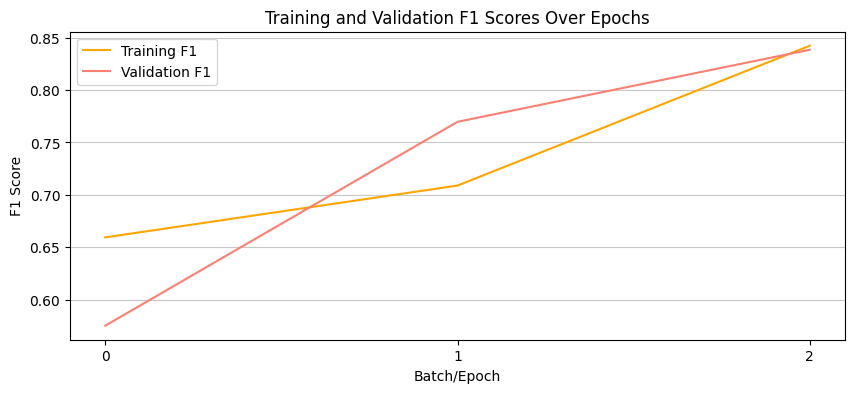

In [23]:
plt.figure(figsize=(10, 4))
sea.lineplot(x=loss_df['batch'], y=loss_df['training metric'], color='orange', label='Training F1')
sea.lineplot(x=loss_df['batch'], y=loss_df['val metric'], color='salmon', label='Validation F1')
plt.title('Training and Validation F1 Scores Over Epochs')
plt.xlabel('Batch/Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.xticks(np.arange(0, num_epochs, step=1))  # Ajuste conforme necessário
plt.grid(axis='y', alpha=0.7)
plt.show()

#### Predictions on New Data

In [69]:
model.eval()
predictions, probs = [], []

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits    
    probs.append(softmax(outputs.logits, dim=-1))
    predictions.append(torch.argmax(softmax(outputs.logits, dim=-1)))


In [70]:
label_mapping_inverse = {v: k for k,v in label_mapping.items()}

df_test['predictions'] = [p.item() for p in predictions]
df_test['category automatic'] = df_test['predictions'].apply(lambda x: label_mapping_inverse[x])
y_true_ids = df_test['label'].values
y_pred_ids = df_test['predictions'].values

y_true_labels = df_test['Category'].values
y_pred_labels = df_test['category automatic'].values

In [71]:
data = []
precision = np.round(precision_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
recall = np.round(recall_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
f1 = np.round(f1_score(y_true_ids, y_pred_ids, average='macro', zero_division=0), 3)
data.append(['Fine Tuning (Validation)', precision, recall, f1, total_time])            

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print(classification_report(y_true_labels, y_pred_labels, zero_division=0))

Precision: 0.694
Recall: 0.695
F1 Score: 0.693
               precision    recall  f1-score   support

        Covid       0.50      0.42      0.45        24
Entertainment       0.73      0.76      0.75        25
       Sports       0.85      0.91      0.88        44

     accuracy                           0.74        93
    macro avg       0.69      0.70      0.69        93
 weighted avg       0.73      0.74      0.73        93



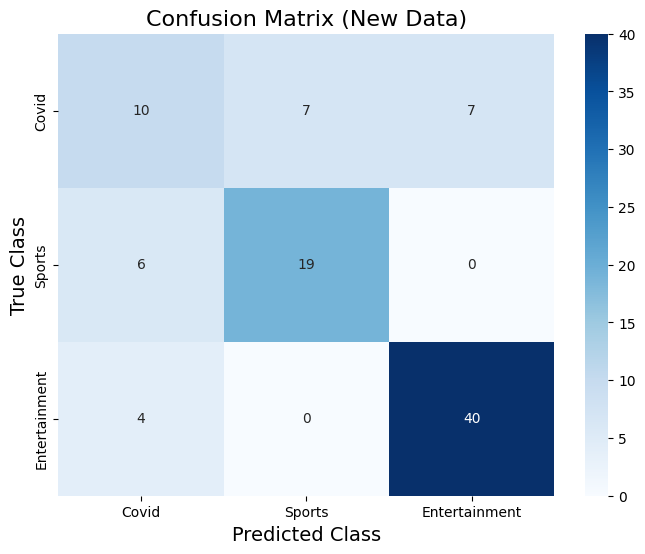

In [72]:
target_names = model.config.id2label.keys()
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (New Data)', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.show()


### PEFT/LORA Adapter

In [28]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [29]:
lora_config = LoraConfig(
    r=8, # dimensions
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['query', 'values'],
    bias="none",
    task_type=TaskType.TOKEN_CLS
)

# Prepare model
peft_model = get_peft_model(model, lora_config)
peft_model.to(device)
print(print_number_of_trainable_model_parameters(model))


trainable model parameters: 152070
all model parameters: 167508486
percentage of trainable model parameters: 0.09%


In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr=10e-5, weight_decay=0.01)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [46]:
val_training_metric, val_losses, all_training_metric, all_losses, total_time = training_loop(train_dataloader, eval_dataloader, num_epochs, peft_model, optimizer, lr_scheduler, device, model_type='peft')

 33%|███▎      | 362/1086 [01:00<01:53,  6.35it/s]

epoch 1/3 - mean loss: 0.3853 - f1 score: 0.8624 - accuracy: 0.8728


Epoch 1: Saving best model with F1 0.8454


 67%|██████▋   | 724/1086 [02:08<00:55,  6.57it/s]

epoch 2/3 - mean loss: 0.3611 - f1 score: 0.8775 - accuracy: 0.8866


100%|██████████| 1086/1086 [03:15<00:00,  6.54it/s]

epoch 3/3 - mean loss: 0.3471 - f1 score: 0.8876 - accuracy: 0.8949


100%|██████████| 1086/1086 [03:23<00:00,  5.34it/s]

Training completed successfully in 3.39 minutes


#### Evaluation Loop

In [47]:
loss_df = pd.DataFrame()
loss_df['batch'] = range(num_epochs)
loss_df['training loss'] = [l for l in all_losses]
loss_df['val loss'] = [l for l in val_losses]
loss_df['training metric'] =  [item['f1'] for item in all_training_metric]
loss_df['val metric'] =  [item['f1'] for item in val_training_metric]

loss_df

,batch,training loss,val loss,training metric,val metric
0,0,0.385320,0.445015,0.862437,0.845398
1,1,0.361142,0.436678,0.877458,0.835319
2,2,0.347053,0.436769,0.887627,0.836194


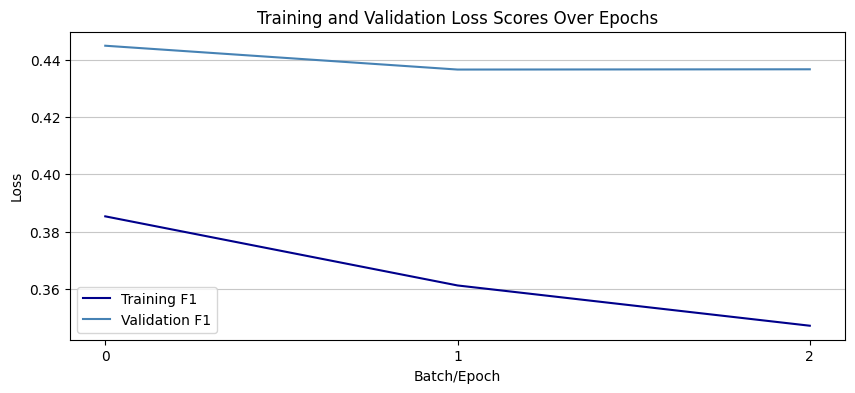

In [48]:
plt.figure(figsize=(10, 4))
sea.lineplot(x=loss_df['batch'], y=loss_df['training loss'], color='darkblue', label='Training F1')
sea.lineplot(x=loss_df['batch'], y=loss_df['val loss'], color='steelblue', label='Validation F1')
plt.title('Training and Validation Loss Scores Over Epochs')
plt.xlabel('Batch/Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.xticks(np.arange(0, num_epochs, step=1))  # Ajuste conforme necessário
plt.grid(axis='y', alpha=0.7)
plt.show()

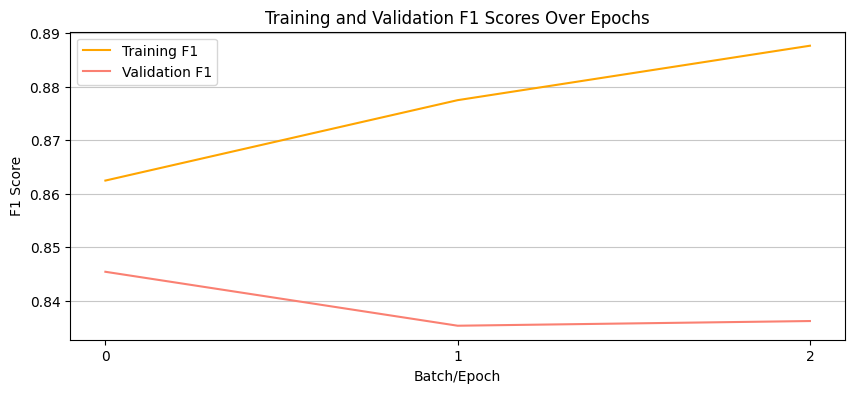

In [49]:
plt.figure(figsize=(10, 4))
sea.lineplot(x=loss_df['batch'], y=loss_df['training metric'], color='orange', label='Training F1')
sea.lineplot(x=loss_df['batch'], y=loss_df['val metric'], color='salmon', label='Validation F1')
plt.title('Training and Validation F1 Scores Over Epochs')
plt.xlabel('Batch/Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.xticks(np.arange(0, num_epochs, step=1))  # Ajuste conforme necessário
plt.grid(axis='y', alpha=0.7)
plt.show()

#### Predictions on New Data

In [73]:
peft_model.eval()
predictions, probs = [], []

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = peft_model(**batch)
    logits = outputs.logits    
    probs.append(softmax(outputs.logits, dim=-1))
    predictions.append(torch.argmax(softmax(outputs.logits, dim=-1)))


In [74]:
label_mapping_inverse = {v: k for k,v in label_mapping.items()}
df_test['predictions'] = [p.item() for p in predictions]
df_test['category automatic'] = df_test['predictions'].apply(lambda x: label_mapping_inverse[x])
y_true_ids = df_test['label'].values
y_pred_ids = df_test['predictions'].values

y_true_labels = df_test['Category'].values
y_pred_labels = df_test['category automatic'].values

In [75]:
peft_precision = np.round(precision_score(y_true_ids, y_pred_ids, average='weighted', zero_division=0), 3)
peft_recall = np.round(recall_score(y_true_ids, y_pred_ids, average='weighted', zero_division=0), 3)
peft_f1 = np.round(f1_score(y_true_ids, y_pred_ids, average='weighted', zero_division=0), 3)
data.append(['PEFT (Validation)', peft_precision, peft_recall, peft_f1, total_time])            
print(f"Precision: {peft_precision}")
print(f"Recall: {peft_recall}")
print(f"F1 Score: {peft_f1}")

print(classification_report(y_true_labels, y_pred_labels, zero_division=0))

Precision: 0.728
Recall: 0.742
F1 Score: 0.734
               precision    recall  f1-score   support

        Covid       0.50      0.42      0.45        24
Entertainment       0.73      0.76      0.75        25
       Sports       0.85      0.91      0.88        44

     accuracy                           0.74        93
    macro avg       0.69      0.70      0.69        93
 weighted avg       0.73      0.74      0.73        93



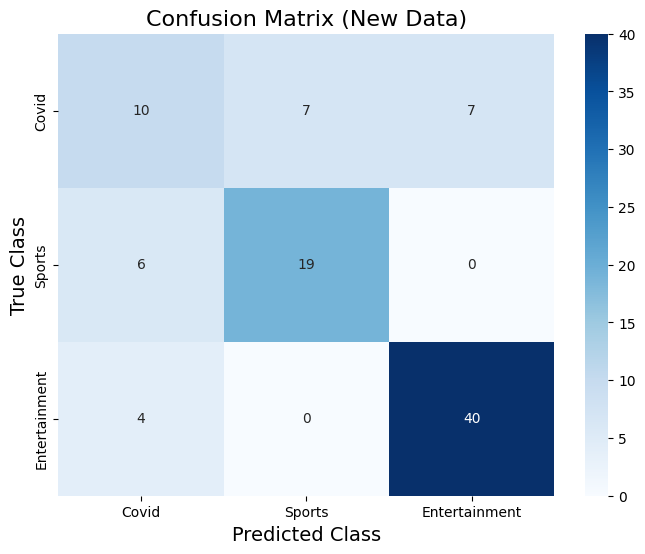

In [53]:
target_names = peft_model.config.id2label.keys()
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (New Data)', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.show()


### Metrics x Time (Fine Tuning x PEFT)

In [76]:
metrics_df = pd.DataFrame(data, columns=['Strategy', 'Precision', 'Recall', 'F1', 'Training Time'])           
metrics_df

,Strategy,Precision,Recall,F1,Training Time
0,Fine Tuning (Validation),0.694,0.695,0.693,5.99826
1,PEFT (Validation),0.728,0.742,0.734,3.38802


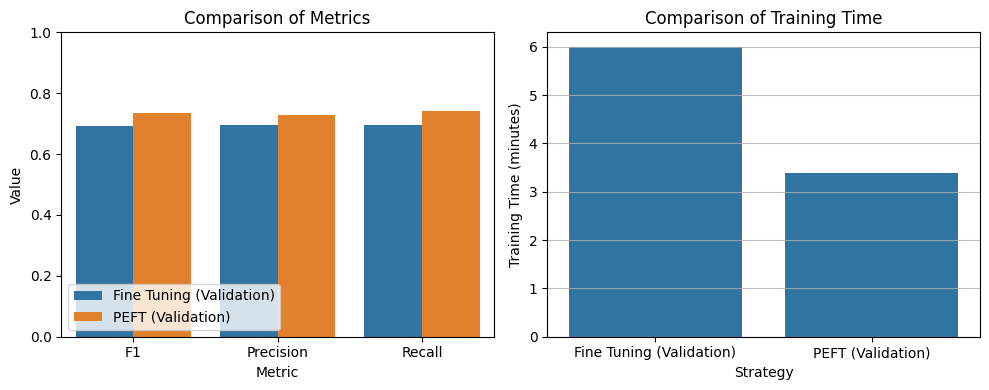

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df = metrics_df[['Strategy', 'F1', 'Precision', 'Recall']].melt(id_vars='Strategy', var_name='Metric', value_name='Value')
sea.barplot(data=df, x='Metric', y='Value', hue='Strategy', ax=axes[0])
axes[0].legend(loc='lower left')
axes[0].set_ylim(0, 1)
axes[0].set_title('Comparison of Metrics')
sea.barplot(data=metrics_df, x='Strategy', y='Training Time', ax=axes[1])
axes[1].set_title('Comparison of Training Time')
axes[1].set_ylabel('Training Time (minutes)')
plt.grid(axis='y', alpha=0.8)
plt.tight_layout()
plt.show()

Better metrics in less processing time